# CIFAR 10 Classifier

CIFAR10 is a classic data set for image recognition, which contains 10 types of pictures. The dataset has 60,000 color images of size 32 x 32, of which 50,000 are used for training and 10,000 are used for testing.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

We will device to GPU, thus we should determine the GPU available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

Load and normalize CIFAR10\
We will load dataset from `torchvision`. `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` means that the mean and respective std value and as the dataset contains three channel.This method will normalize the image data that is between (0,1) to (-1,1).

In [4]:
transform_tr = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(), #data preprocess-> data intensify
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# test data don't need to intensify
transform_te = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_tr)


test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_te)

# the classes of the pictures
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print('Train data information:\n',train_set)
print('Test data information:\n',test_set)

Train data information:
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomGrayscale(p=0.1)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data information:
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Preparing data for training with DataLoaders \
We will remove 10,000 images from the training set and call this our validation set. The dataset also includes labels for each image.Set the batch size to B = 20. This means that we will pass through the entire data in 2000 iterations, which is called on epoch. We will use `DataLoader` to split and assemble data in 3 sets and shuffle in each set.

In [6]:
from torch.utils.data import DataLoader,Subset
# Set random seed
np.random.seed(0)
order = np.random.permutation(len(train_set))
validation = Subset(train_set, order[0:10000])
train = Subset(train_set, order[10000:])
batch_size = 20

loaders = {
    'train' : DataLoader(train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0),
    
    'validation' : DataLoader(validation, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0),
    
    'test'  : DataLoader(test_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1efa17d1450>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x1efa17d0be0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1efa17d0d90>}

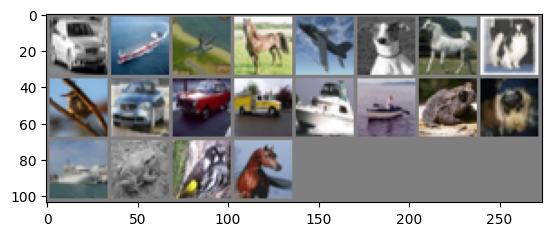

car   ship  plane horse plane dog   horse dog   bird  car   car   truck ship  ship  frog  dog   ship  frog  bird  horse


In [7]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(loaders['train'])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Create a CNN model\
Theis model include 3 convolution blocks, that each block consists of 2 convolution functions, 2 ReLU active function and 1 Pooling. Besides, there are 3 linear functions.

In [8]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1                  
            ),
            nn.BatchNorm2d(32), # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )        
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.conv3 = nn.Sequential(         
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),     
            nn.ReLU(),
            nn.MaxPool2d(2),                
        )
        
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=.3) #Randomly zero out each element 
  
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x



Define the cost function and optimizer

In [9]:
learning_rate = 0.001
epochs = 30

In [10]:
model = CNN()
criterion = nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


Use GPU\
By default, the tensors are generated on the CPU. Even the model is initialized on the CPU. Thus one has to manually ensure that the operations are done using GPU. 
We need to transform the input,output and model to GPU.

In [11]:
length_tr = len(loaders['train'])
length_val = len(loaders['validation'])
loss_validation = torch.zeros((epochs,1), dtype=torch.float64).to(device)
acc_validation = torch.zeros((epochs,1), dtype=torch.float64).to(device)
accuracy_val_list = torch.empty((length_val,1), dtype=torch.float64).to(device)
loss_train = torch.zeros((epochs,1), dtype=torch.float64).to(device)
acc_train = torch.zeros((epochs,1), dtype=torch.float64).to(device)
accuracy_tr_list = torch.empty((length_tr,1), dtype=torch.float64).to(device)


In [12]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [13]:
# Loop over epochs
for epoch in range(epochs):
    # Loop over batches in an epoch using DataLoader
    loss_tr = torch.empty((length_tr,1), dtype=torch.float64).to(device)
    loss_val = torch.empty((length_val,1), dtype=torch.float64).to(device)
    #Training set
    for id_batch, (x_batch, y_batch) in enumerate(loaders['train']):
    # Remember that you will have to send the inputs and targets at every step to the GPU too:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch)
        loss_tr[id_batch][0] = loss
        
        optimizer.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
    
        total_tr = y_batch.size(0)
        correct_tr = (torch.argmax(y_batch_pred,dim=1) == y_batch).sum()
        accuracy_tr = 100 * correct_tr / total_tr
        accuracy_tr_list[id_batch][0] = accuracy_tr
   
    acc_train[epoch][0] = torch.mean(accuracy_tr_list,dtype=torch.float64)    
    loss_train[epoch][0] = torch.mean(loss_tr,dtype=torch.float64 )
    if epoch % 5 == 0:
        print(f'epoch:{epoch+1}\t Train_loss pro epoch:{loss_train[epoch][0]}\ Accuracy pro epoch:{acc_train[epoch][0]}')
    
    # Validation set
    for id_batch, (x_batch, y_batch) in enumerate(loaders['validation']):
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch_pred = model(x_batch)       
        validation_loss = criterion(y_batch_pred, y_batch)
        loss_val[id_batch][0] = validation_loss
        optimizer.zero_grad()
        validation_loss.backward()
        optimizer.step()
        
        total_val = y_batch.size(0)
        correct_val = (torch.argmax(y_batch_pred,dim=1) == y_batch).sum()
        accuracy_val = 100 * correct_val / total_val
        accuracy_val_list[id_batch][0] = accuracy_val

    acc_validation[epoch][0] = torch.mean(accuracy_val_list,dtype=torch.float64) 
    loss_validation[epoch][0] = torch.mean(loss_val,dtype=torch.float64)

    if epoch % 5 == 0:
        print(f'epoch:{epoch+1}\t Validation_loss pro epoch:{loss_validation[epoch][0]}\ Accuracy pro epoch:{acc_validation[epoch][0]}')
    
print('Finished Training')

epoch:1	 Train_loss pro epoch:1.7483224891126157\ Accuracy pro epoch:34.4525
epoch:1	 Validation_loss pro epoch:1.5216954667568208\ Accuracy pro epoch:44.14
epoch:6	 Train_loss pro epoch:0.7900452866852283\ Accuracy pro epoch:73.32000000000001
epoch:6	 Validation_loss pro epoch:0.7445742735564709\ Accuracy pro epoch:74.83
epoch:11	 Train_loss pro epoch:0.5628834625035525\ Accuracy pro epoch:81.2675
epoch:11	 Validation_loss pro epoch:0.5423452389389276\ Accuracy pro epoch:81.82000000000001
epoch:16	 Train_loss pro epoch:0.46728033101931216\ Accuracy pro epoch:84.8225
epoch:16	 Validation_loss pro epoch:0.45984773457050326\ Accuracy pro epoch:85.16
epoch:21	 Train_loss pro epoch:0.39711763928830623\ Accuracy pro epoch:87.1775
epoch:21	 Validation_loss pro epoch:0.3777376913279295\ Accuracy pro epoch:87.46000000000001
epoch:26	 Train_loss pro epoch:0.35648864762904126\ Accuracy pro epoch:88.6125
epoch:26	 Validation_loss pro epoch:0.3378591382987797\ Accuracy pro epoch:88.97
Finished Tra

In [14]:
# Save model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

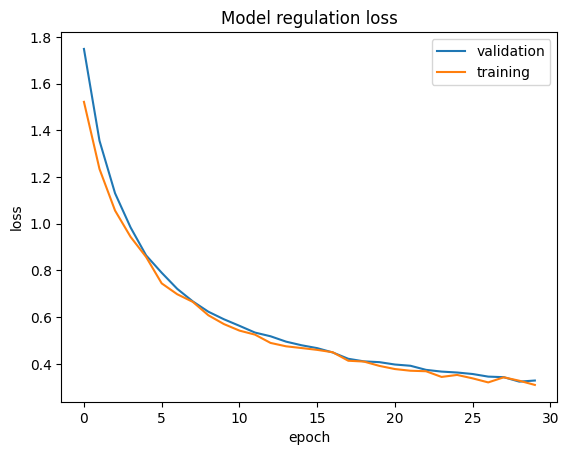

In [15]:
plt.plot(loss_train.cpu().detach().numpy().tolist())
plt.plot(loss_validation.cpu().detach().numpy().tolist())
plt.legend(['validation','training'])
plt.title('Model regulation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

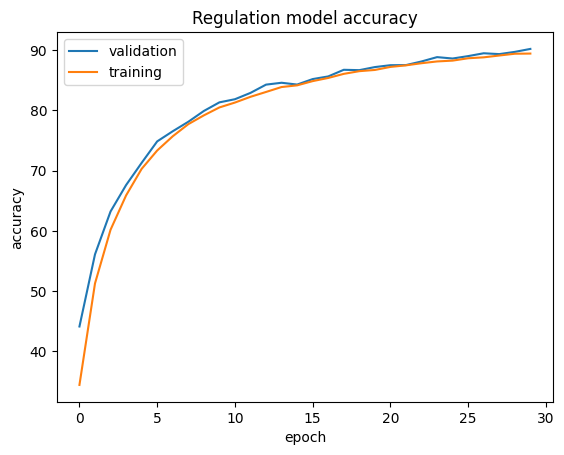

In [16]:
plt.plot(acc_validation.cpu().detach().numpy().tolist())
plt.plot(acc_train.cpu().detach().numpy().tolist())
plt.legend(['validation','training'])
plt.title('Regulation model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [17]:
model.load_state_dict(torch.load('cifar_net.pth'))
model.eval()

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for images, labels in loaders['test']:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

    '''
    total_test = batch_size
    correct_test = (torch.argmax(outputs,dim=1) == labels).sum()
    acc_test = 100 * correct_test / total_test
'''


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 84.0 %
Accuracy for class: car   is 89.1 %
Accuracy for class: bird  is 76.3 %
Accuracy for class: cat   is 78.2 %
Accuracy for class: deer  is 83.7 %
Accuracy for class: dog   is 78.6 %
Accuracy for class: frog  is 89.1 %
Accuracy for class: horse is 92.4 %
Accuracy for class: ship  is 92.9 %
Accuracy for class: truck is 92.5 %


In [18]:
# print accuracy of all classes
total_num = 0
total_correct_num = 0
total_accuracy = 0
for classname, correct_count in correct_pred.items():
    total_num = total_num + total_pred[classname]
    total_correct_num = total_correct_num + correct_count

total_accuracy = 100 * float(total_correct_num) / total_num
print(f'Accuracy for all classes: {total_accuracy:.1f} %')

Accuracy for all classes: 85.7 %
